In [73]:
import pandas as pd
import numpy as np
from DataGenerator import TimeSeriesGenerator
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
pd.options.plotting.backend = "plotly"

# Linear time series

A linear time series can be written as: $$ y_{t} = C_{t} \cdot X_{t}$$ 
With $C_{t}$ being hidden coefficients and $X_{t}$ being observable variables such that:

$$ Y_{t} = \sum_{i=1}^n c_{it} * x_{it}$$

The main idea behind our experimental setup is that the models are only given $X_{t}$ and essentially have to learn something that closely *mimics* $C_{t}$. 

We can directly introduce drift by changing $C$ as from a certain timepoint $T=t$. Our main assumption is that given a change in $C_{t}$ there are sufficient strategies to reduce the negative impact on $\hat{y}_{t}$, this is not our immediate focus.

We want to introduce drift in the aforementioned way *and* remove corresponding variable from the dataset that is given to the learner. Our goals are threefold:

- Can we identify when drift occurs?
- If so, can we find solutions to mitigate the impact of drift in the short term?
- Both being true: can this inform us on the optimal way and time to retrain our model(s)?

To achieve this we made a `TimeSeriesGenerator` class that allows us to generate time series in the form specified above.

With the current seed the hidden coefficients of the variables are as follows (with seed 42): 

`[0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594, 0.37079802, 0.92676499, 0.64386512, 0.82276161, 0.4434142]`

The initial values for the time series are:
`[8, 77, 65, 43, 43, 85,  8, 69, 20,  9]`

At each time step these base values are multiplied by a random number uniformly sampled from $[0.99, 1.04[$. 

This result represents the observable values $X_{t}$, $X_{t}$ is then multiplied by the hidden coefficients to produce $Y_{t}$ after the errors have been added.

Additionally the `generateTrend()`, `generateSeasonality()` can add trend and/or seasonality to any number of variables.
## No drift

The first case is a time series with additive trend and seasonality.


In [2]:
WithoutDrift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
WithoutDrift.generateTrend([0,2], [2,4])
WithoutDrift.generateSeasonality(periods=2, indices=0)
WithoutDrift.calculate()
WithoutDrift_df = WithoutDrift.toDataFrame(frequency='D')
WithoutDrift_df.head()

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-01-01,16.183167,77.387813,131.115810,42.796363,44.430877,85.280655,8.012825,69.613597,20.882844,9.340092,310.716084,2016,52,7
2017-01-02,16.651882,79.242066,131.984156,43.808480,44.905381,86.755473,8.090429,70.961153,20.455367,8.976971,317.857831,2017,1,1
2017-01-03,16.662929,77.677563,132.750176,43.547414,44.689613,86.406187,8.281680,68.870067,20.909580,9.169502,311.402077,2017,1,2
2017-01-04,16.875518,77.345682,130.530088,43.516148,44.421200,88.992976,8.241138,70.575268,20.338317,9.357225,318.757737,2017,1,3
2017-01-05,17.434068,77.583834,133.263388,43.589398,44.634201,89.080781,8.257756,68.978820,20.503364,8.974140,318.764127,2017,1,4


In [14]:
fig = px.line(WithoutDrift_df,x=WithoutDrift_df.index, y="Response", title = f"Seasonal time series with {WithoutDrift_df.shape[0]} observations")
fig.update_layout(title_x = 0.5)
fig.show()

### Baseline: Model with full knowledge

In [21]:
X = WithoutDrift_df.drop("Response", axis="columns")
y = WithoutDrift_df["Response"].copy()
timeSeriesSPlits = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=3000,
    test_size=200,
)

all_splits = list(timeSeriesSPlits.split(X, y))
train_0, test_0 = all_splits[0]

In [23]:
GBR_pipeline = make_pipeline(HistGradientBoostingRegressor())
RF_pipeline = make_pipeline(RandomForestRegressor())

In [24]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [25]:
evaluate(GBR_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     6.570 +/- 1.065
Root Mean Squared Error: 7.609 +/- 1.173


In [26]:
evaluate(RF_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     7.113 +/- 1.462
Root Mean Squared Error: 8.205 +/- 1.509


In [78]:
GBR_pipeline.fit(X.iloc[:-200], y.iloc[:-200])
GBR_predictions = pd.Series(GBR_pipeline.predict(X.iloc[-200:]))
#GBR_residuals = y.iloc[:-200] - GBR_predictions

RF_pipeline.fit(X.iloc[:-200], y.iloc[:-200])
RF_predictions = pd.Series(RF_pipeline.predict(X.iloc[-200:]) )
#RF_residuals = y.iloc[:-200] - RF_predictions

SES_predictions = SimpleExpSmoothing(y).fit(smoothing_level=1).predict(-200, None)
SES_residuals = SimpleExpSmoothing(y).fit(smoothing_level=1).resid
predictions = pd.concat([y.iloc[-200:].reset_index(), GBR_predictions, RF_predictions, SES_predictions.reset_index(drop=True)], axis = 1)
predictions = predictions.rename({0: "Gradient_boosted_tree", 1 : "Random_Forest", 2: "SES"}, axis =1)

In [80]:
fig = predictions.plot(labels = (index="index"))
fig.show()

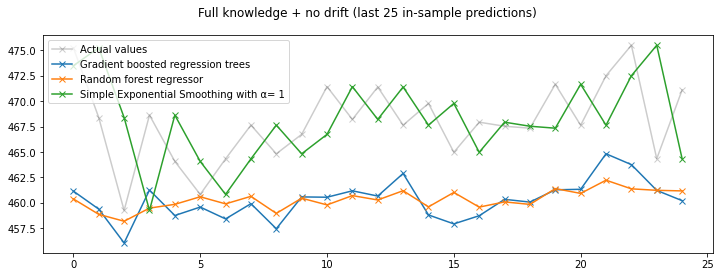

In [28]:
days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift (last 25 in-sample predictions)")
ax.plot(
    y.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions[days],
    "x-",
    label="Random forest regressor",
)

ax.plot(
    SES_predictions.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)
_ = ax.legend()


In [29]:
SES_MAE = np.mean(np.abs(SES_residuals))
print(f"The MAE of SES is {SES_MAE}")

The MAE of SES is 3.836326223511656


#### Discussion

Both tree based models work pretty well out of the box as they have no problems capturing non-linear effects. A simple exponential smoothing model with α = 1 simply predicts the previous value at each time step. Currently as there are no strong deviations (e.g. one day having a significantly higher/lower level of sales) that punish this behaviour.

**Before we move to the case without full knowledge we need to make the data generator better. SES will outperform RF and GBRT since it only uses Y values either way.** 

Ways to improve the generation process: 

- ~~Include days of the week as a dummy variable and include coefficients for it. It should be lower on certain days.~~ This has been implemented through the `weeklyPattern()`method.
- Same could be done for months.
- The next y-value could *explicitly* be a function of the previous one. This is currently not the case.
- Suggestions?

#### Adjustment to TimeSeriesGenerator: adding variation based on day of the week

The coefficients are multiplied by [1.1, 1.05, 1.07, 1.03, 1.12, 1.07, 1.04] based on the day of the week. 

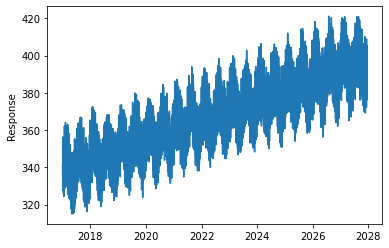

In [30]:
weeklyPattern = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
weeklyPattern.weeklyPattern()
weeklyPattern.generateTrend([0,2], [1.5,2])
weeklyPattern.generateSeasonality(periods=2, indices=0)
weeklyPattern.calculate()
weekly_df = weeklyPattern.toDataFrame(frequency='D')
X_WK = weekly_df.drop(columns="Response", axis = 1)
y_WK = weekly_df["Response"]
fig = sns.lineplot(data=weekly_df,x=weekly_df.index, y="Response")

plt.show()

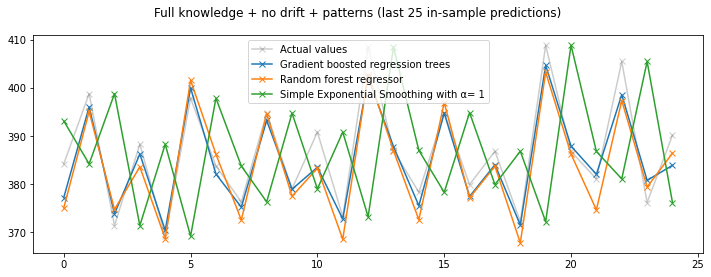

In [31]:
SES_predictions_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).predict(-200, None)
SES_residuals_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).resid

SES_8 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).resid

SES_6 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).resid

SES_4 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_WK.iloc[:-200], y_WK.iloc[:-200])
GBR_predictions_WK = GBR_pipeline.predict(X_WK.iloc[-200:])  

RF_pipeline.fit(X_WK.iloc[:-200], y_WK.iloc[:-200])
RF_predictions_WK = RF_pipeline.predict(X_WK.iloc[-200:])



days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift + patterns (last 25 in-sample predictions)")
ax.plot(
    y_WK.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions_WK[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions_WK[days],
    "x-",
    label="Random forest regressor",
)
ax.plot(
    SES_predictions_WK.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

_ = ax.legend()

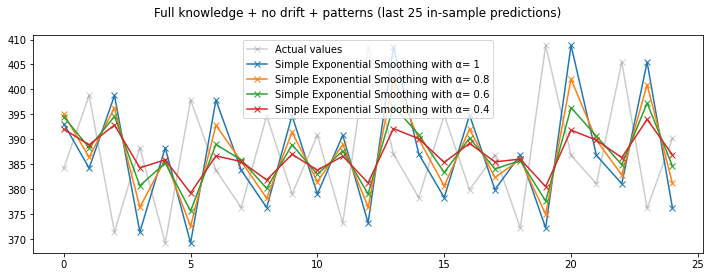

In [32]:
days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift + patterns (last 25 in-sample predictions)")
ax.plot(
    y_WK.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    SES_predictions_WK.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

ax.plot(
    SES_8.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.8",
)
ax.plot(
    SES_6.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.6",
)

ax.plot(
    SES_4.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.4",
)
_ = ax.legend()

In [33]:
evaluate(GBR_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     3.220 +/- 0.190
Root Mean Squared Error: 3.981 +/- 0.198


In [34]:
evaluate(RF_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     4.033 +/- 0.372
Root Mean Squared Error: 4.937 +/- 0.387


In [35]:
MAE_1 = np.mean(np.abs(SES_residuals_WK))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 16.35699508916023
The MAE of SES with α = 0.8 is 14.2509246605026
The MAE of SES with α = 0.6 is 12.414399866926408
The MAE of SES with α = 0.4 is 10.92287655844471


#### Discussion and conclusions

- When putting structural patterns into the data SES with $\alpha$ = 1 doesn't do well anymore.
- The current approach of generating this type of seasonality was done by altering the "hidden" coefficients with a fixed rate.
  - Is this the right way to do it? Should this be directly observeable in the variables or not?
- Both random forest and gradient boosted trees perform better on this case than the previous.
  - Intuition: Day, Month, Year are explicit features. Could they have (correctly) attached some feature importance to Day while in the previous setting it was "distracting" it?
- Should the daily pattern be slightly random?
- Mainly: **Is it fair to try something first and then go back and change the setup to fit your purpose?**

## Drift
### Sudden drift

In the following section we will try and recreate an experiment carried out by Baier et al. called the Error intersection approach (EIA). The key insight is that given sudden drift the exponentially weighted moving average (EWMA) of the errors of a simple model $M_{simple}$ will intersect that of a complex model $M_{complex}$ given that $M_{complex}$ is a static model and $M_{simple}$ is a model that focusses on forecasting based on information of the previous time windows. After they intersect the model that currently has the lowest EWMA carries out the predictions. The The amount of intersections also gives an indication of how many times drift occured in a certain time window.

In the original paper a neural network was used for $M_{complex}$, $M_{simple}$ was not explicitly mentioned. We will use initially use a gradient boosted regression tree and random forest for the former and SES for the latter.

We will pay close attention to the following parameters that need to be tuned:
- The span for the EWMA, the paper used 6 but this is likely domain / time series specific. How do we determine determine this parameter?
- Tuning the $\alpha$ parameter of SES.
- Ultimately: their mutual relationship. A higher $\alpha$ reacts better to sudden drift but is less resillient to noise. The same applies for the span parameter.
  
**The paper also did their experiment in the context of a blizzard. This kind of occurence dissapears. Does this approach also hold for persistent drift?**

Most likely: if there is an intersection and $M_{simple}$ remains above $M_{complex}$ you need to retrain... But does this give us additional information above just looking at a residual plot?



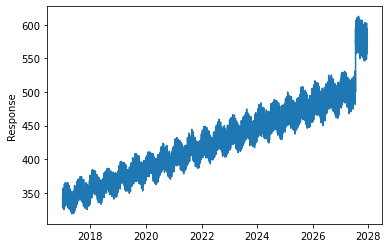

In [36]:
Drift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
Drift.weeklyPattern()
Drift.generateSuddenDrift(-2,3850, 5)
Drift.generateTrend([0,2], [2,4])
Drift.generateSeasonality(periods=2, indices=0)
Drift.calculate()
Drift_df = Drift.toDataFrame(frequency='D')
X_DR =  Drift_df.drop(columns="Response", axis = 1)
y_DR =  Drift_df["Response"]
fig = sns.lineplot(data=Drift_df,x=Drift_df.index, y="Response")
plt.show()

In [37]:
evaluate(GBR_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     17.104 +/- 21.156
Root Mean Squared Error: 19.762 +/- 24.076


In [38]:
evaluate(RF_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     19.173 +/- 22.316
Root Mean Squared Error: 21.843 +/- 25.129


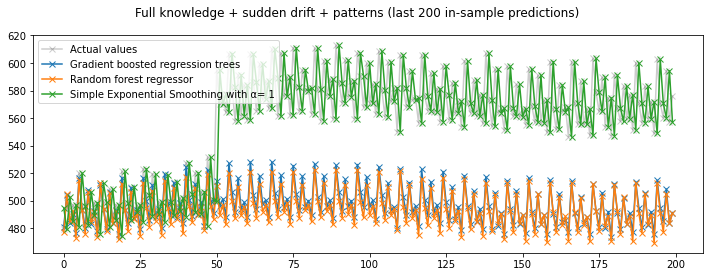

In [39]:
SES_predictions_SDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).predict(-200, None)
SES_residuals_SDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).resid

SES_8 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).resid

SES_6 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).resid

SES_4 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
GBR_predictions_SDR = GBR_pipeline.predict(X_DR.iloc[-200:])  

RF_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
RF_predictions_SDR = RF_pipeline.predict(X_DR.iloc[-200:])



days = slice(-200, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + sudden drift + patterns (last 200 in-sample predictions)")
ax.plot(
    y_DR.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions_SDR[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions_SDR[days],
    "x-",
    label="Random forest regressor",
)
ax.plot(
    SES_predictions_SDR.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

_ = ax.legend()

In [40]:
MAE_1 = np.mean(np.abs(SES_residuals_WK))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 16.35699508916023
The MAE of SES with α = 0.8 is 16.568584688385982
The MAE of SES with α = 0.6 is 14.406108385323549
The MAE of SES with α = 0.4 is 12.633781008329029


#### Discussion and conclusions

- Results make sense, GBRT and RFR were trained on the first 3800 examples. When drift occured at the 3850'th time point the static models struggled. The SES models aren't as affected by this fact.
- Considering we have full knowledge we could retrain the static models at this point to recover $\hat{y}$, is this something we should prove? For now we'll just move on running under the assumption you *can* do it.

### Incremental drift

`TimeSeriesGenerator` has two methods to achieve this namely `LinearIncrementalDrift()` and `LogIncrementalDrift()`. We will be looking at the linear case but this section could be expanded later.

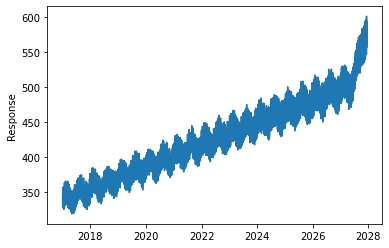

In [41]:
IncrementalDrift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
IncrementalDrift.weeklyPattern()
IncrementalDrift.generateLinearIncrementalDrift(-2,3800, 4000, 5)
IncrementalDrift.generateTrend([0,2], [2,4])
IncrementalDrift.generateSeasonality(periods=2, indices=0)
IncrementalDrift.calculate()
IncrementalDrift_df = IncrementalDrift.toDataFrame(frequency='D')
X_DR =  IncrementalDrift_df.drop(columns="Response", axis = 1)
y_DR =  IncrementalDrift_df["Response"]
fig = sns.lineplot(data=IncrementalDrift_df,x=IncrementalDrift_df.index, y="Response")
plt.show()

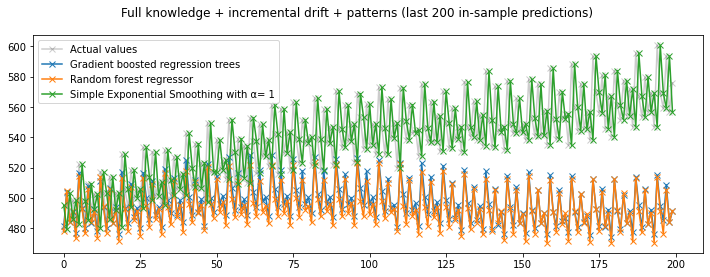

In [44]:
SES_predictions_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).predict(-200, None)
SES_residuals_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).resid

SES_8_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).resid

SES_6_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).resid

SES_4_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
GBR_predictions_IDR = GBR_pipeline.predict(X_DR.iloc[-200:])  

RF_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
RF_predictions_IDR = RF_pipeline.predict(X_DR.iloc[-200:])



days = slice(-200, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + incremental drift + patterns (last 200 in-sample predictions)")
ax.plot(
    y_DR.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions_IDR[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions_IDR[days],
    "x-",
    label="Random forest regressor",
)
ax.plot(
    SES_predictions_IDR.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

_ = ax.legend()

In [45]:
evaluate(GBR_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     13.473 +/- 13.894
Root Mean Squared Error: 15.619 +/- 15.791


In [46]:
evaluate(RF_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     15.576 +/- 15.001
Root Mean Squared Error: 17.629 +/- 16.601


In [47]:
MAE_1 = np.mean(np.abs(SES_residuals_IDR))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 18.989594078588837
The MAE of SES with α = 0.8 is 16.512702357541233
The MAE of SES with α = 0.6 is 14.34964110024471
The MAE of SES with α = 0.4 is 12.572423674046165


#### Results and discussion
 
- SES outperforms the complex models decisvely as from $\alpha$ = 0.4
- This is a contrived set-up, the model was *only* trained on pre-drift data and *only* has to predict post-drift data. Are there suggestions to make this better?
  

### Future plans

#### Perfecting the current baseline
- Improve our synthetic data generation process
- Improve the setting of the baseline and further tests: when to introduce drift, how much drift, how many variables
- Tune $\alpha$ properly
- Add an additional model: Linear Regression with feature engineering (?)

#### Extending the baseline
- Implement most common methods from the literature: Page-Hinkley, ADWIN, EDDM, SPC and test them on our current set-up
- Case without full knowledge, removing variables:
  - How do we determine what variable(s) to drop?
  - How many do we drop?
  
#### Error intersection approach and beyond

- Study the relationship between the span parameter of EWMA and $\alpha$ as they aren't given in the paper. Is this problem dependent? Can we at least get a sense of what drives the choice of either one?
- Do the detectors align or not?
- Actually make the EIA classifier(s):
  -  An ensemble with $\alpha_{opt}$ which we will find in our research above that switches between both
  -  Same as above but a weighted prediction between both
  -  Can several $\alpha$ and span parameters detect different kinds of drift? 
- Can any of the infomation listed above inform of us on training?

